In [ ]:
#!unzip /content/Train.zip

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transform

In [ ]:
data = ImageFolder('/content/Train/',transform=transform.ToTensor())

In [ ]:
t1_train = Subset(data,list(range(0,28)))
t2_train = Subset(data,list(range(28,56)))

In [ ]:
t1_train_dl = DataLoader(t1_train,1)
t2_train_dl = DataLoader(t2_train,1)

# T1-Weighted Images

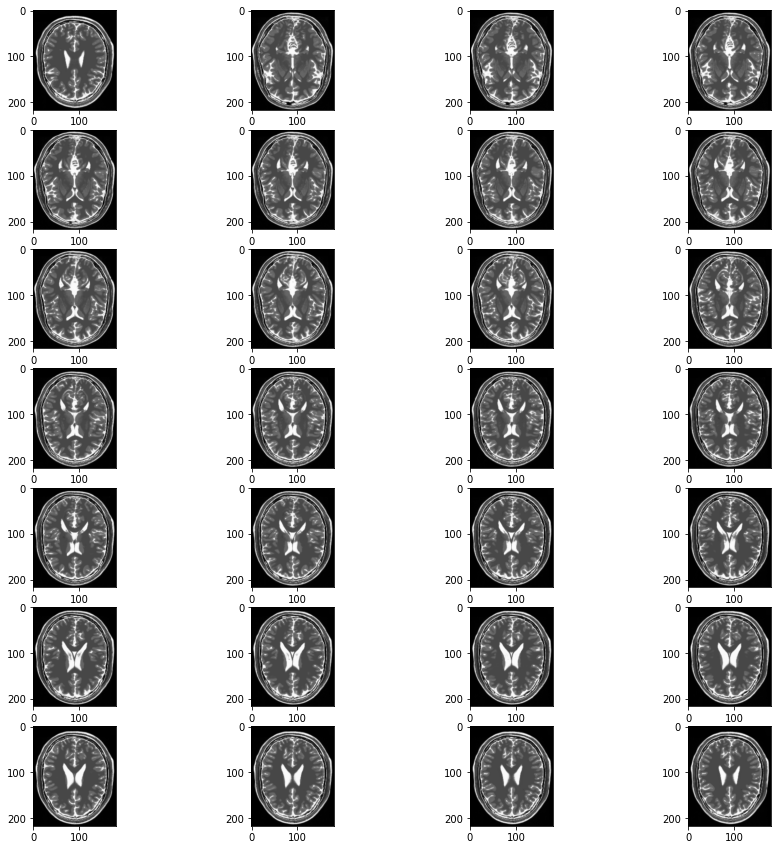

In [ ]:
ax,fig = plt.subplots(7,4,figsize=(15,15))
r=c=1
for img,lab in t1_train_dl:
  fig[r-1][c-1].imshow(img[0].permute(1,2,0),cmap='gray')
  if c%4==0:
    r = r+1
  c = (c+1)%4

# T2-Weighted Images

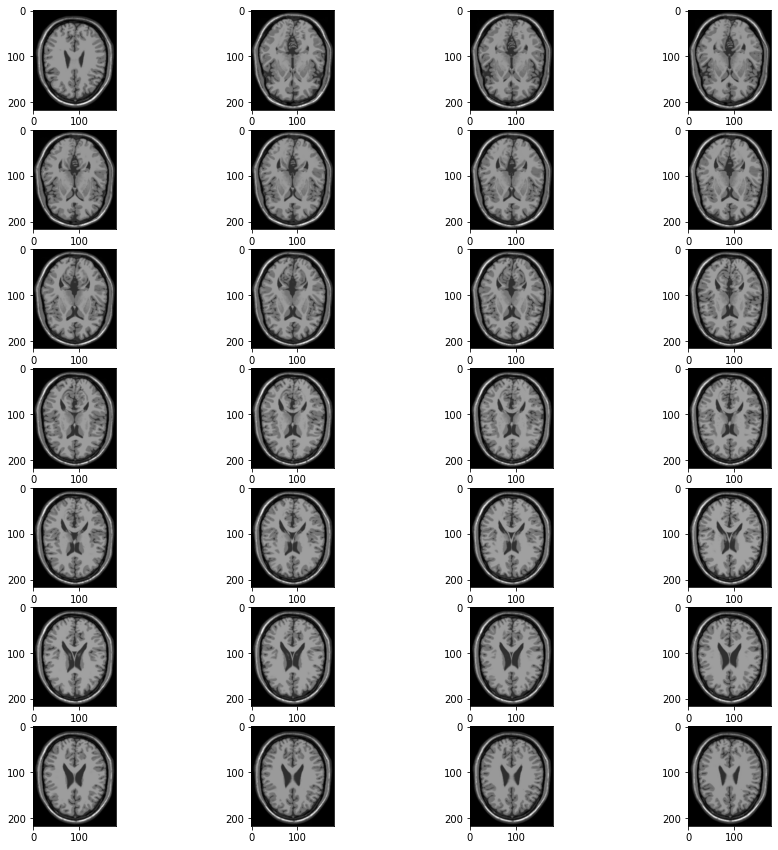

In [ ]:
ax,fig = plt.subplots(7,4,figsize=(15,15))
r=c=1
for img,lab in t2_train_dl:
  fig[r-1][c-1].imshow(img[0].permute(1,2,0),cmap='gray')
  if c%4==0:
    r = r+1
  c = (c+1)%4

# Preprocessing

In [ ]:
#!pip install antspyx

In [ ]:
import ants

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Biase-Field-Correction

In [ ]:
def correct(images):
  imgtensor = []
  for i in range(len(images)):
    img = ants.from_numpy(images[i][0].numpy())
    corrected = ants.n3_bias_field_correction(img)
    imgtensor.append(corrected.numpy())
  return th.tensor(imgtensor)

In [ ]:
t1_train_bfc = correct(t1_train)

In [ ]:
t2_train_bfc = correct(t2_train)

In [ ]:
t1_train_pre = th.utils.data.Subset(t1_train_bfc,list(range(0,len(t1_train_bfc))))
t2_train_pre = th.utils.data.Subset(t2_train_bfc,list(range(0,len(t2_train_bfc))))

In [ ]:
t1_train_pre_dl = DataLoader(t1_train_pre,1)

## Comparing Correted Images

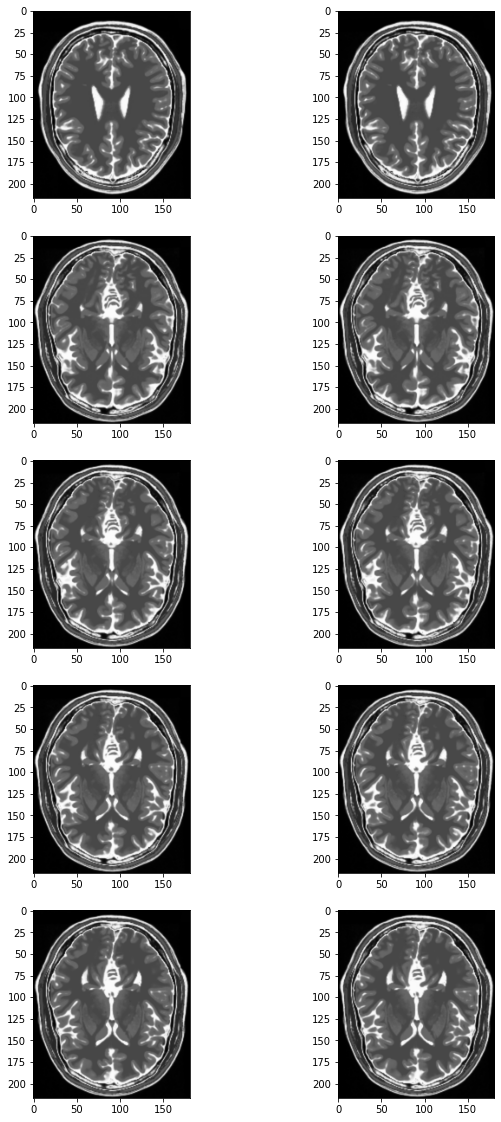

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(10,20))
for i in range(len(t1_train)):
  im1 = t1_train[i][0]
  im2 = t1_train_pre[i]
  ax[i][0].imshow(im1.permute(1,2,0),cmap='gray')
  ax[i][1].imshow(im2.permute(1,2,0),cmap='gray')
  if i>=4:
    break

In [ ]:
image = ants.image_read(ants.get_ants_data('r16'))
mask = ants.get_mask(image)
fuzzy = ants.fuzzy_spatial_cmeans_segmentation(image, mask, number_of_clusters=3)

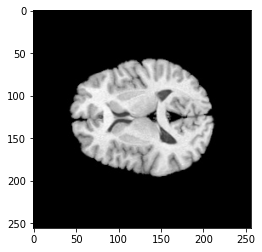

In [ ]:
plt.imshow(image.numpy(),cmap='gray')

In [ ]:
fuzzy

{'probability_images': [ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (256, 256)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.], ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (256, 256)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.], ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (256, 256)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]], 'segmentation_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.]}

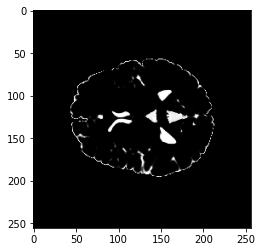

In [ ]:
plt.imshow(fuzzy['probability_images'][0].numpy(),cmap='gray')

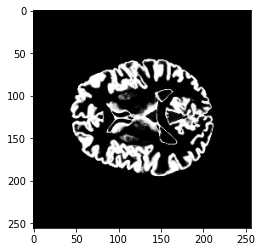

In [ ]:
plt.imshow(fuzzy['probability_images'][1].numpy(),cmap='gray')

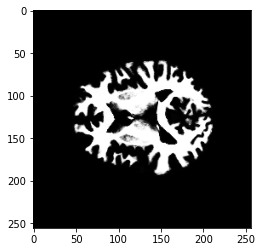

In [ ]:
plt.imshow(fuzzy['probability_images'][2].numpy(),cmap='gray')

In [ ]:
def seg_slice(image):
  seg0 = []
  seg1 = []
  seg2 = []
  for i in range(len(image)):
    print('Image " ',i)
    img = ants.from_numpy(image[i].numpy())
    mask = ants.get_mask(img)
    fuzzy = ants.fuzzy_spatial_cmeans_segmentation(img, mask, number_of_clusters=3)['probability_images']
    seg0.append(fuzzy[0].numpy())
    seg1.append(fuzzy[1].numpy())
    seg2.append(fuzzy[2].numpy())
  return (th.tensor(seg0),th.tensor(seg1),th.tensor(seg2))

In [ ]:
#t1_train_seg0,t1_train_seg1,t1_train_seg2 = seg_slice(t1_train_pre)

In [ ]:
len(t2_train_pre)

28

In [ ]:
t2_train_seg0,t2_train_seg1,t2_train_seg2 = seg_slice(t2_train_pre)

Image "  0
Image "  1
Image "  2
Image "  3
Image "  4
Image "  5
Image "  6
Image "  7
Image "  8
Image "  9
Image "  10
Image "  11
Image "  12
Image "  13
Image "  14
Image "  15
Image "  16
Image "  17
Image "  18
Image "  19
Image "  20
Image "  21
Image "  22
Image "  23
Image "  24
Image "  25
Image "  26
Image "  27


In [ ]:
len(t2_train_seg1)

28

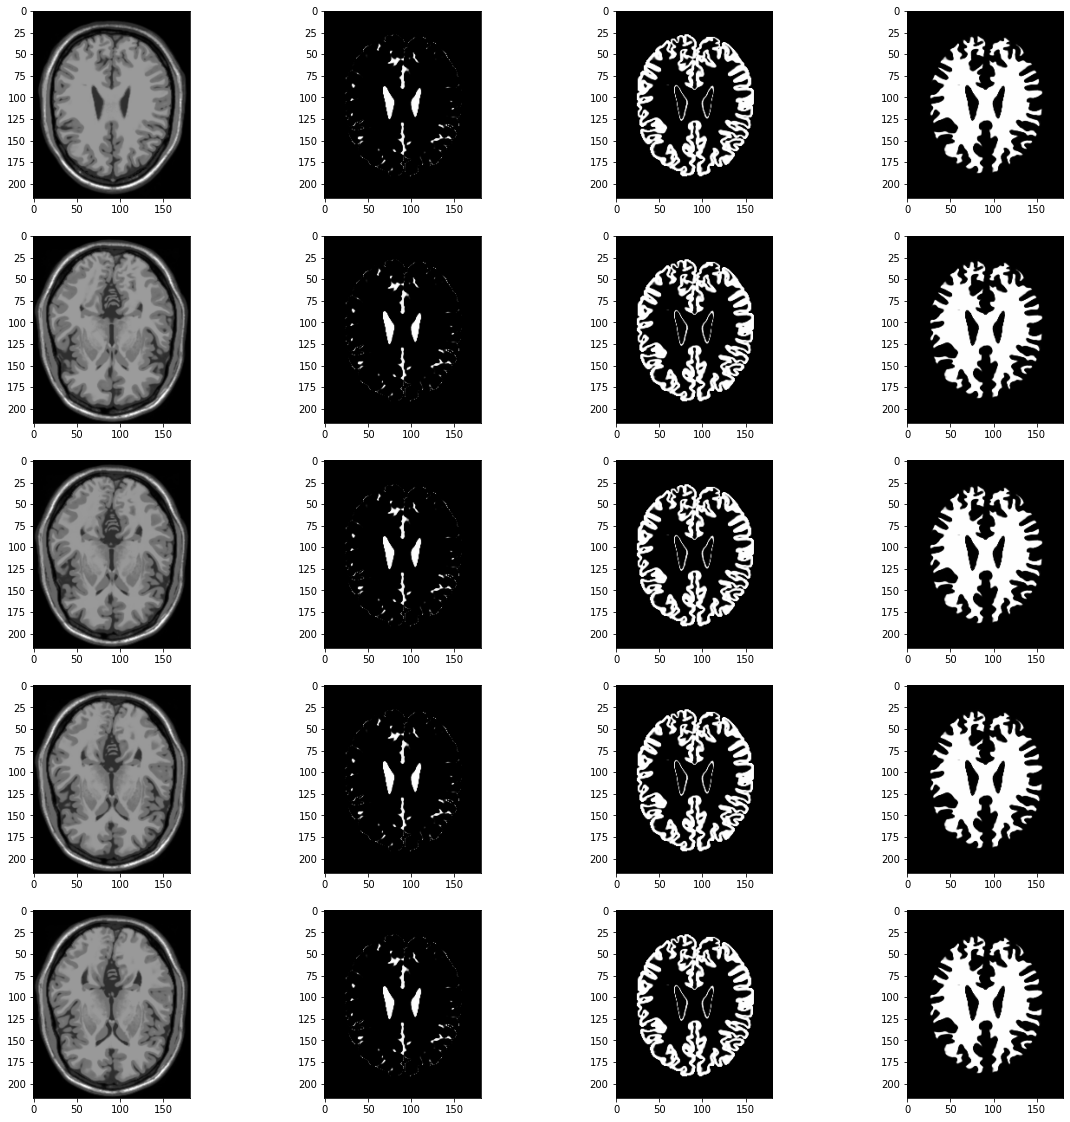

In [ ]:
 fig,ax = plt.subplots(5,4,figsize=(20,20))
for i in range(len(t2_train)):
  im00 = t2_train_pre[i]
  im0 = t2_train_seg0
  im1 = t2_train_seg1
  im2 = t2_train_seg2
  ax[i][0].imshow(im00.permute(1,2,0),cmap='gray')
  ax[i][1].imshow(im0.permute(1,2,0),cmap='gray')
  ax[i][2].imshow(im1.permute(1,2,0),cmap='gray')
  ax[i][3].imshow(im2.permute(1,2,0),cmap='gray')
  if i>=4:
    break

# Model Building

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Mod2(nn.Module):
  def __init__(self):
    super(Mod2,self).__init__()
    self.lay1 = nn.Conv2d(3,32,3,2,1)
    self.lay2 = nn.Conv2d(32,64,3,2,1)
    self.lay3 = nn.Conv2d(64,128,3,1,0)#53.0 44.0

    self.mean = nn.Linear(128*53*44,128)
    self.log_var = nn.Linear(128*53*44,128)
    
    self.decFCL = nn.Linear(128,128*53*44)
    self.declay2 = nn.ConvTranspose2d(128,64,3,1,0)
    self.declay1 = nn.ConvTranspose2d(64,32,3,2,1)
    self.declay0 = nn.ConvTranspose2d(32,3,3,2,1)


  def encoder(self,x):

    x = F.leaky_relu(self.lay1(x))
    x = F.leaky_relu(self.lay2(x))
    x = F.leaky_relu(self.lay3(x))
    x = x.view(-1,128*53*44)
    mu = self.mean(x)
    logvar = self.log_var(x)
    return mu,logvar

  def reparameterize(self, mu, logVar):
    std = th.exp(logVar/2)
    eps = th.randn_like(std)
    return mu + std * eps


  def decoder(self,x):
    x = F.leaky_relu(self.decFCL(x))
    x = x.view(-1,128,53,44)
    x = F.leaky_relu(self.declay2(x))
    x = F.leaky_relu(self.declay1(x))
    #x = F.pad(x,(0,0,2,0))
    x = F.leaky_relu(self.declay0(x))
    x = F.sigmoid(x)
    return x



  def forward(self,x):
    mu,logvar = self.encoder(x)
    z = self.reparameterize(mu,logvar)
    out = self.decoder(z)
    return out,mu,logvar



In [ ]:
learning_rate = 0.001
num_epochs = 100

In [ ]:

"""
Initialize the network and the Adam optimizer
"""
device='cuda'
net = Mod2().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
Loss1 = []

In [ ]:



"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""

for epoch in tqdm(range(num_epochs)):
    ii = 0
    losss = []
    for i in t1_train_pre_dl:
        tar = t2_train_seg2[ii].to(device)
        imgs = i
        #print(imgs.shape)
        #imgs = imgs[0]
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.mse_loss(out[0], tar) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('l> : ',float(loss))
        ii = ii + 1
        losss.append(loss)
    Loss1.append(float(sum(losss)/len(losss)))
    print('Epoch {}: Loss {}'.format(epoch, loss))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

  1%|          | 1/100 [00:02<04:04,  2.47s/it]

Epoch 0: Loss 0.08544240891933441


  2%|▏         | 2/100 [00:04<03:58,  2.44s/it]

Epoch 1: Loss 0.1031351163983345


  3%|▎         | 3/100 [00:07<03:55,  2.43s/it]

Epoch 2: Loss 0.0969497486948967


  4%|▍         | 4/100 [00:09<03:52,  2.42s/it]

Epoch 3: Loss 0.09409480541944504


  5%|▌         | 5/100 [00:12<03:49,  2.42s/it]

Epoch 4: Loss 0.07523641735315323


  6%|▌         | 6/100 [00:14<03:47,  2.42s/it]

Epoch 5: Loss 0.09087839722633362


  7%|▋         | 7/100 [00:16<03:44,  2.41s/it]

Epoch 6: Loss 0.0798441469669342


  8%|▊         | 8/100 [00:19<03:42,  2.41s/it]

Epoch 7: Loss 0.07211937010288239


  9%|▉         | 9/100 [00:21<03:39,  2.41s/it]

Epoch 8: Loss 0.08129341900348663


 10%|█         | 10/100 [00:24<03:37,  2.41s/it]

Epoch 9: Loss 0.09747446328401566


 11%|█         | 11/100 [00:26<03:34,  2.41s/it]

Epoch 10: Loss 0.09327634423971176


 12%|█▏        | 12/100 [00:29<03:32,  2.41s/it]

Epoch 11: Loss 0.07285717874765396


 13%|█▎        | 13/100 [00:31<03:30,  2.41s/it]

Epoch 12: Loss 0.09385957568883896


 14%|█▍        | 14/100 [00:33<03:27,  2.41s/it]

Epoch 13: Loss 0.08756069839000702


 15%|█▌        | 15/100 [00:36<03:25,  2.41s/it]

Epoch 14: Loss 0.08878322690725327


 16%|█▌        | 16/100 [00:38<03:22,  2.41s/it]

Epoch 15: Loss 0.09682334959506989


 17%|█▋        | 17/100 [00:41<03:20,  2.41s/it]

Epoch 16: Loss 0.0752873569726944


 18%|█▊        | 18/100 [00:43<03:17,  2.41s/it]

Epoch 17: Loss 0.09538102895021439


 19%|█▉        | 19/100 [00:45<03:15,  2.41s/it]

Epoch 18: Loss 0.07109452039003372


 20%|██        | 20/100 [00:48<03:13,  2.41s/it]

Epoch 19: Loss 0.08138617128133774


 21%|██        | 21/100 [00:50<03:10,  2.41s/it]

Epoch 20: Loss 0.08778627961874008


 22%|██▏       | 22/100 [00:53<03:08,  2.41s/it]

Epoch 21: Loss 0.09234033524990082


 23%|██▎       | 23/100 [00:55<03:05,  2.41s/it]

Epoch 22: Loss 0.09250343590974808


 24%|██▍       | 24/100 [00:57<03:03,  2.41s/it]

Epoch 23: Loss 0.08786552399396896


 25%|██▌       | 25/100 [01:00<03:00,  2.41s/it]

Epoch 24: Loss 0.1065554991364479


 26%|██▌       | 26/100 [01:02<02:58,  2.41s/it]

Epoch 25: Loss 0.09876338392496109


 27%|██▋       | 27/100 [01:05<02:55,  2.41s/it]

Epoch 26: Loss 0.07044058293104172


 28%|██▊       | 28/100 [01:07<02:53,  2.41s/it]

Epoch 27: Loss 0.09171688556671143


 29%|██▉       | 29/100 [01:10<02:51,  2.41s/it]

Epoch 28: Loss 0.09156113117933273


 30%|███       | 30/100 [01:12<02:48,  2.41s/it]

Epoch 29: Loss 0.09020815044641495


 31%|███       | 31/100 [01:14<02:46,  2.41s/it]

Epoch 30: Loss 0.09028127044439316


 32%|███▏      | 32/100 [01:17<02:44,  2.41s/it]

Epoch 31: Loss 0.08815162628889084


 33%|███▎      | 33/100 [01:19<02:41,  2.41s/it]

Epoch 32: Loss 0.0873192772269249


 34%|███▍      | 34/100 [01:22<02:39,  2.41s/it]

Epoch 33: Loss 0.07421178370714188


 35%|███▌      | 35/100 [01:24<02:36,  2.41s/it]

Epoch 34: Loss 0.08583160489797592


 36%|███▌      | 36/100 [01:26<02:34,  2.41s/it]

Epoch 35: Loss 0.0846521407365799


 37%|███▋      | 37/100 [01:29<02:32,  2.41s/it]

Epoch 36: Loss 0.07034722715616226


 38%|███▊      | 38/100 [01:31<02:29,  2.41s/it]

Epoch 37: Loss 0.08378159254789352


 39%|███▉      | 39/100 [01:34<02:27,  2.41s/it]

Epoch 38: Loss 0.10144098103046417


 40%|████      | 40/100 [01:36<02:24,  2.41s/it]

Epoch 39: Loss 0.077489472925663


 41%|████      | 41/100 [01:38<02:22,  2.41s/it]

Epoch 40: Loss 0.09400583803653717


 42%|████▏     | 42/100 [01:41<02:20,  2.41s/it]

Epoch 41: Loss 0.09736905246973038


 43%|████▎     | 43/100 [01:43<02:17,  2.41s/it]

Epoch 42: Loss 0.07941490411758423


 44%|████▍     | 44/100 [01:46<02:15,  2.41s/it]

Epoch 43: Loss 0.08536111563444138


 45%|████▌     | 45/100 [01:48<02:12,  2.42s/it]

Epoch 44: Loss 0.07869661599397659


 46%|████▌     | 46/100 [01:51<02:10,  2.41s/it]

Epoch 45: Loss 0.07532282918691635


 47%|████▋     | 47/100 [01:53<02:07,  2.41s/it]

Epoch 46: Loss 0.08027924597263336


 48%|████▊     | 48/100 [01:55<02:05,  2.41s/it]

Epoch 47: Loss 0.08109037578105927


 49%|████▉     | 49/100 [01:58<02:03,  2.41s/it]

Epoch 48: Loss 0.09852907806634903


 50%|█████     | 50/100 [02:00<02:00,  2.41s/it]

Epoch 49: Loss 0.08106805384159088


 51%|█████     | 51/100 [02:03<01:58,  2.41s/it]

Epoch 50: Loss 0.08284052461385727


 52%|█████▏    | 52/100 [02:05<01:55,  2.41s/it]

Epoch 51: Loss 0.0890110656619072


 53%|█████▎    | 53/100 [02:07<01:53,  2.41s/it]

Epoch 52: Loss 0.07413379102945328


 54%|█████▍    | 54/100 [02:10<01:50,  2.41s/it]

Epoch 53: Loss 0.07939330488443375


 55%|█████▌    | 55/100 [02:12<01:48,  2.41s/it]

Epoch 54: Loss 0.08932334929704666


 56%|█████▌    | 56/100 [02:15<01:46,  2.41s/it]

Epoch 55: Loss 0.0838853269815445


 57%|█████▋    | 57/100 [02:17<01:43,  2.41s/it]

Epoch 56: Loss 0.08690140396356583


 58%|█████▊    | 58/100 [02:20<01:41,  2.41s/it]

Epoch 57: Loss 0.07491065561771393


 59%|█████▉    | 59/100 [02:22<01:38,  2.41s/it]

Epoch 58: Loss 0.0733058974146843


 60%|██████    | 60/100 [02:24<01:36,  2.41s/it]

Epoch 59: Loss 0.08510642498731613


 61%|██████    | 61/100 [02:27<01:34,  2.42s/it]

Epoch 60: Loss 0.09112655371427536


 62%|██████▏   | 62/100 [02:29<01:31,  2.41s/it]

Epoch 61: Loss 0.07731347531080246


 63%|██████▎   | 63/100 [02:32<01:29,  2.41s/it]

Epoch 62: Loss 0.08559063822031021


 64%|██████▍   | 64/100 [02:34<01:26,  2.41s/it]

Epoch 63: Loss 0.07310143858194351


 65%|██████▌   | 65/100 [02:36<01:24,  2.41s/it]

Epoch 64: Loss 0.09188563376665115


 66%|██████▌   | 66/100 [02:39<01:22,  2.41s/it]

Epoch 65: Loss 0.07460927963256836


 67%|██████▋   | 67/100 [02:41<01:19,  2.41s/it]

Epoch 66: Loss 0.09119531512260437


 68%|██████▊   | 68/100 [02:44<01:17,  2.42s/it]

Epoch 67: Loss 0.06821145862340927


 69%|██████▉   | 69/100 [02:46<01:14,  2.42s/it]

Epoch 68: Loss 0.06615182012319565


 70%|███████   | 70/100 [02:48<01:12,  2.41s/it]

Epoch 69: Loss 0.10632310807704926


 71%|███████   | 71/100 [02:51<01:09,  2.41s/it]

Epoch 70: Loss 0.08150804042816162


 72%|███████▏  | 72/100 [02:53<01:07,  2.41s/it]

Epoch 71: Loss 0.07600878924131393


 73%|███████▎  | 73/100 [02:56<01:05,  2.41s/it]

Epoch 72: Loss 0.08787298202514648


 74%|███████▍  | 74/100 [02:58<01:02,  2.41s/it]

Epoch 73: Loss 0.08726871758699417


 75%|███████▌  | 75/100 [03:01<01:00,  2.41s/it]

Epoch 74: Loss 0.07922763377428055


 76%|███████▌  | 76/100 [03:03<00:57,  2.41s/it]

Epoch 75: Loss 0.10450874269008636


 77%|███████▋  | 77/100 [03:05<00:55,  2.42s/it]

Epoch 76: Loss 0.07238467037677765


 78%|███████▊  | 78/100 [03:08<00:53,  2.42s/it]

Epoch 77: Loss 0.08915719389915466


 79%|███████▉  | 79/100 [03:10<00:50,  2.42s/it]

Epoch 78: Loss 0.07667599618434906


 80%|████████  | 80/100 [03:13<00:48,  2.42s/it]

Epoch 79: Loss 0.07933911681175232


 81%|████████  | 81/100 [03:15<00:45,  2.42s/it]

Epoch 80: Loss 0.07156635820865631


 82%|████████▏ | 82/100 [03:17<00:43,  2.42s/it]

Epoch 81: Loss 0.06283806264400482


 83%|████████▎ | 83/100 [03:20<00:41,  2.41s/it]

Epoch 82: Loss 0.07929067313671112


 84%|████████▍ | 84/100 [03:22<00:38,  2.41s/it]

Epoch 83: Loss 0.08132372051477432


 85%|████████▌ | 85/100 [03:25<00:36,  2.42s/it]

Epoch 84: Loss 0.07433522492647171


 86%|████████▌ | 86/100 [03:27<00:33,  2.42s/it]

Epoch 85: Loss 0.0855315774679184


 87%|████████▋ | 87/100 [03:30<00:31,  2.42s/it]

Epoch 86: Loss 0.06649933755397797


 88%|████████▊ | 88/100 [03:32<00:28,  2.42s/it]

Epoch 87: Loss 0.08859533071517944


 89%|████████▉ | 89/100 [03:34<00:26,  2.42s/it]

Epoch 88: Loss 0.07464662939310074


 90%|█████████ | 90/100 [03:37<00:24,  2.42s/it]

Epoch 89: Loss 0.08432653546333313


 91%|█████████ | 91/100 [03:39<00:21,  2.42s/it]

Epoch 90: Loss 0.07181303948163986


 92%|█████████▏| 92/100 [03:42<00:19,  2.42s/it]

Epoch 91: Loss 0.09446753561496735


 93%|█████████▎| 93/100 [03:44<00:16,  2.42s/it]

Epoch 92: Loss 0.08332529664039612


 94%|█████████▍| 94/100 [03:46<00:14,  2.42s/it]

Epoch 93: Loss 0.0871419683098793


 95%|█████████▌| 95/100 [03:49<00:12,  2.42s/it]

Epoch 94: Loss 0.1020885780453682


 96%|█████████▌| 96/100 [03:51<00:09,  2.42s/it]

Epoch 95: Loss 0.08016934245824814


 97%|█████████▋| 97/100 [03:54<00:07,  2.42s/it]

Epoch 96: Loss 0.09230750799179077


 98%|█████████▊| 98/100 [03:56<00:04,  2.42s/it]

Epoch 97: Loss 0.08699990063905716


 99%|█████████▉| 99/100 [03:59<00:02,  2.42s/it]

Epoch 98: Loss 0.0839255303144455


100%|██████████| 100/100 [04:01<00:00,  2.41s/it]

Epoch 99: Loss 0.07194359600543976


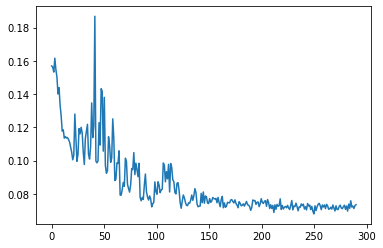

In [ ]:
l = Loss1[10:]
plt.plot(np.linspace(0,len(l),len(l)),l)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



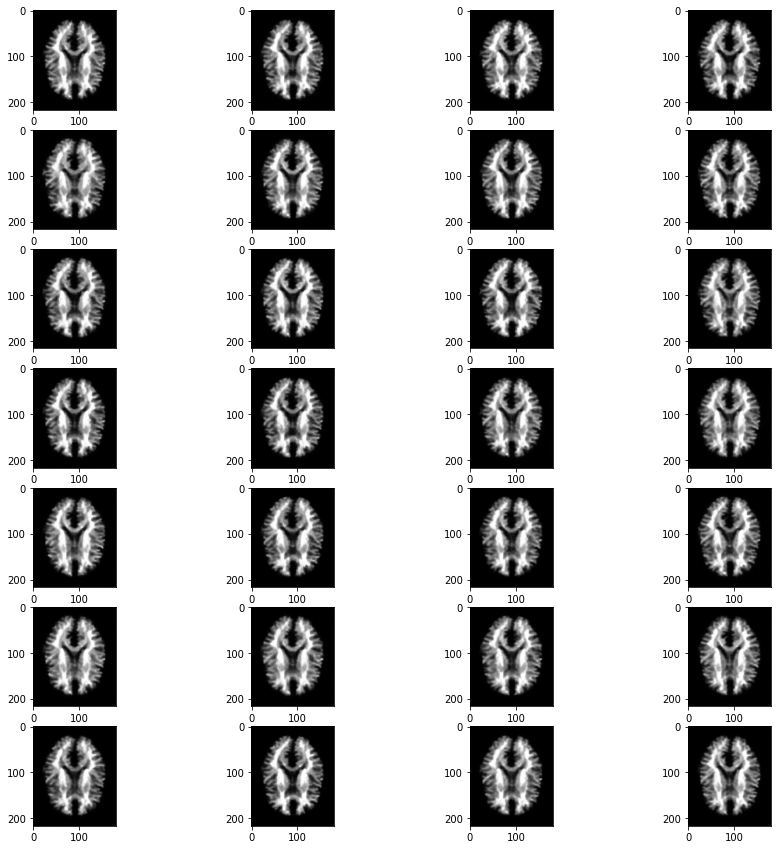

In [ ]:

ax,fig = plt.subplots(7,4,figsize=(15,15))
r=c=1
for img,lab in t1_train_dl:
  img2 = img.to(device)
  im = net.forward(img2)
  im = im[0][0].permute(1,2,0)
  im = im.cpu().detach().numpy()
  fig[r-1][c-1].imshow(im,cmap='gray')
  #plt.show()
  if c%4==0:
    r = r+1
  c = (c+1)%4

In [ ]:
th.save(net,'Mode1_Seg2_0.1_epo30050')

In [ ]:
testdata = ImageFolder('/content/Test/',transform=transform.ToTensor())

In [ ]:
test_dl = DataLoader(testdata,1)

torch.Size([1, 3, 217, 181])
torch.Size([1, 3, 217, 181])
torch.Size([1, 3, 217, 181])
torch.Size([1, 3, 217, 181])
torch.Size([1, 3, 217, 181])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



IndexError: ignored

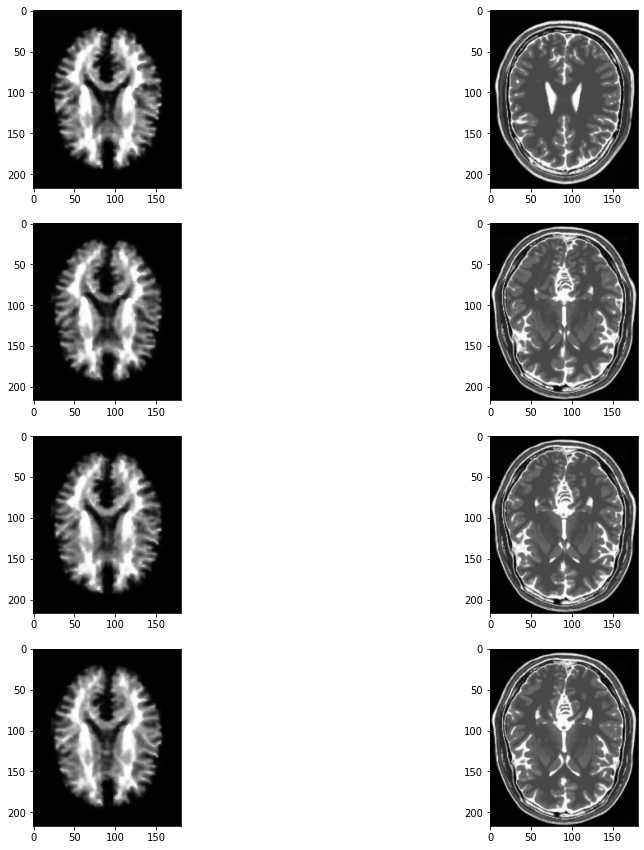

In [ ]:

ax,fig = plt.subplots(4,2,figsize=(15,15))
r=c=1
for img,lab in t1_train_dl:
  img2 = img.to(device)
  print(img2.shape)
  im = net.forward(img2)
  im = im[0][0].permute(1,2,0)
  imz = img2[0].permute(1,2,0)
  imz = imz.cpu().detach().numpy()
  im = im.cpu().detach().numpy()
  fig[r-1][0].imshow(im,cmap='gray')
  fig[r-1][1].imshow(imz,cmap='gray')

  #plt.show()
  #if c%4==0:
  r = r+1
  #c = (c+1)%4